In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

tf.config.list_physical_devices('GPU')

[]

In [15]:
train_set = keras.preprocessing.image_dataset_from_directory(
    'Dataset/Training',
    seed=123,
    interpolation='nearest',
    batch_size=32,
    image_size=(256,256)
)

Found 5712 files belonging to 4 classes.


In [17]:
test_set = keras.preprocessing.image_dataset_from_directory(
    'Dataset/Testing',
    seed=123,
    interpolation='nearest',
    batch_size=32,
    image_size=(256,256)
)

Found 1311 files belonging to 4 classes.


In [18]:
class_names = train_set.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


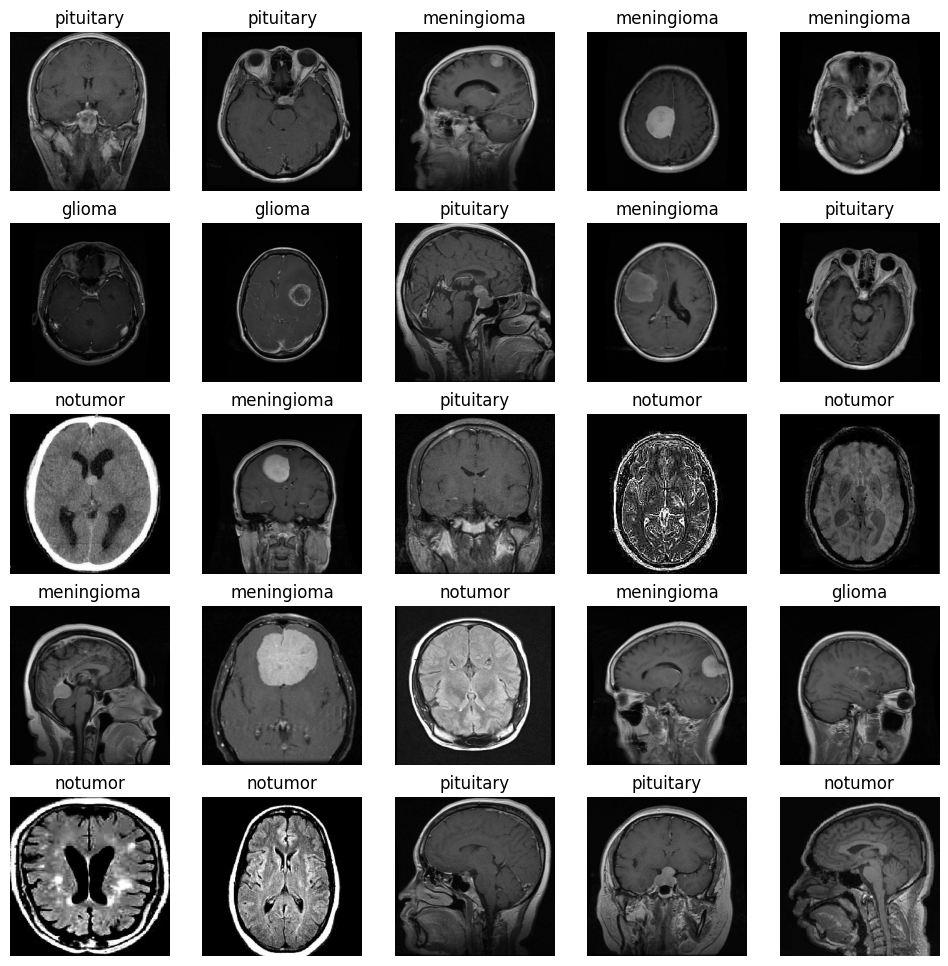

In [19]:
plt.figure(figsize=(12,12))
for img, label in train_set.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title(class_names[label[i]])
        plt.axis('off')

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
def bottleneck_layer(x,filters,strides=1):
    skip_connection = x
    # BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(4*filters,kernel_size=1,strides=strides,padding='same')(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters,kernel_size=3,strides=strides,padding='same')(x)
    
    x = layers.Concatenate()([x,skip_connection])
    return x

In [22]:
# Creating transition layer (pooling layer)
def transition_layer(x):
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(keras.backend.int_shape(x)[-1]//2,kernel_size=1,strides=1,padding='same')(x)
    
    x = layers.AvgPool2D(2,strides=2,padding='same')(x)
    return x

In [23]:
# Creating dense block
def dense_block(x,repetition=1,growth_rate=32):
    for _ in range(repetition):
        x = bottleneck_layer(x,growth_rate)
    return x

In [24]:
# Creating DenseNet-B121
def densenetb121(input_shape,num_classes,growth_rate=32): 
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Initial layer
    x = layers.BatchNormalization()(inputs)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64,kernel_size=7,strides=2,padding='same')(x)
    
    # Pooling layer
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # First dense and transition layer
    x = dense_block(x,6,growth_rate)
    x = transition_layer(x)
    
    # second dense and transition layer
    x = dense_block(x,12,growth_rate)
    x = transition_layer(x)
    
    # Third dense and transition layer
    x = dense_block(x,24,growth_rate)
    x = transition_layer(x)
    
    # Last dense layer
    x = dense_block(x,16,growth_rate)
    
    # Global average pooling layer
    x = layers.GlobalAveragePooling2D()(x)
    
    # Output layer
    outputs = layers.Dense(num_classes,activation='softmax')(x)
    
    model = models.Model(inputs,outputs)
    return model
    

In [ ]:
model = densenetb121(input_shape=(256,256,3),num_classes=len(class_names))

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 3)          12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 256, 256, 3)          0         ['batch_normalization[0][0]'] 
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         9472      ['re_lu[0][0]']           

In [27]:
keras.utils.plot_model(model,show_shapes=True,expand_nested=True,dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
model.compile(
    optimizer=tf.optimizers.Adam(epsilon=0.05),
    loss='sparse_categorical_crossentropy',
    metrics=[metrics.SparseCategoricalAccuracy(name='accuracy')]
             
)

In [35]:
history = model.fit(train_set,
                    validation_data=test_set,
                    epochs=32,
                    batch_size=32)

Epoch 1/32
179/179 [==============================] - 926s 5s/step - loss: 0.0754 - accuracy: 0.9753 - val_loss: 0.7311 - val_accuracy: 0.8162
Epoch 2/32
179/179 [==============================] - 906s 5s/step - loss: 0.0645 - accuracy: 0.9800 - val_loss: 1.3892 - val_accuracy: 0.5545
Epoch 3/32
179/179 [==============================] - 866s 5s/step - loss: 0.0713 - accuracy: 0.9746 - val_loss: 1.0310 - val_accuracy: 0.7193
Epoch 4/32
179/179 [==============================] - 864s 5s/step - loss: 0.0600 - accuracy: 0.9799 - val_loss: 0.5689 - val_accuracy: 0.7948
Epoch 5/32
179/179 [==============================] - 866s 5s/step - loss: 0.0505 - accuracy: 0.9828 - val_loss: 1.8830 - val_accuracy: 0.5225
Epoch 6/32
179/179 [==============================] - 878s 5s/step - loss: 0.0426 - accuracy: 0.9855 - val_loss: 0.6614 - val_accuracy: 0.8131
Epoch 7/32
179/179 [==============================] - 866s 5s/step - loss: 0.0345 - accuracy: 0.9897 - val_loss: 0.3432 - val_accuracy: 0.8986

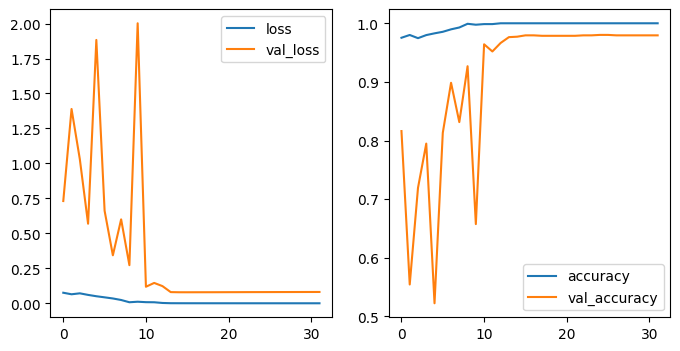

In [36]:
plt.figure(figsize=(8,4))

plt.subplot(121)
hist_df = pd.DataFrame(history.history)
hist_df.loc[:,['loss','val_loss']].plot(ax=plt.gca())


plt.subplot(122)
hist_df.loc[:,['accuracy','val_accuracy']].plot(ax=plt.gca())

plt.show()

In [37]:
loss,accuracy = model.evaluate(test_set)

print('Loss:',loss)
print('Accuracy:',accuracy)

41/41 [==============================] - 42s 1s/step - loss: 0.0810 - accuracy: 0.9794
Loss: 0.08098478615283966
Accuracy: 0.9794050455093384


In [33]:
model.save('best_model.h5')

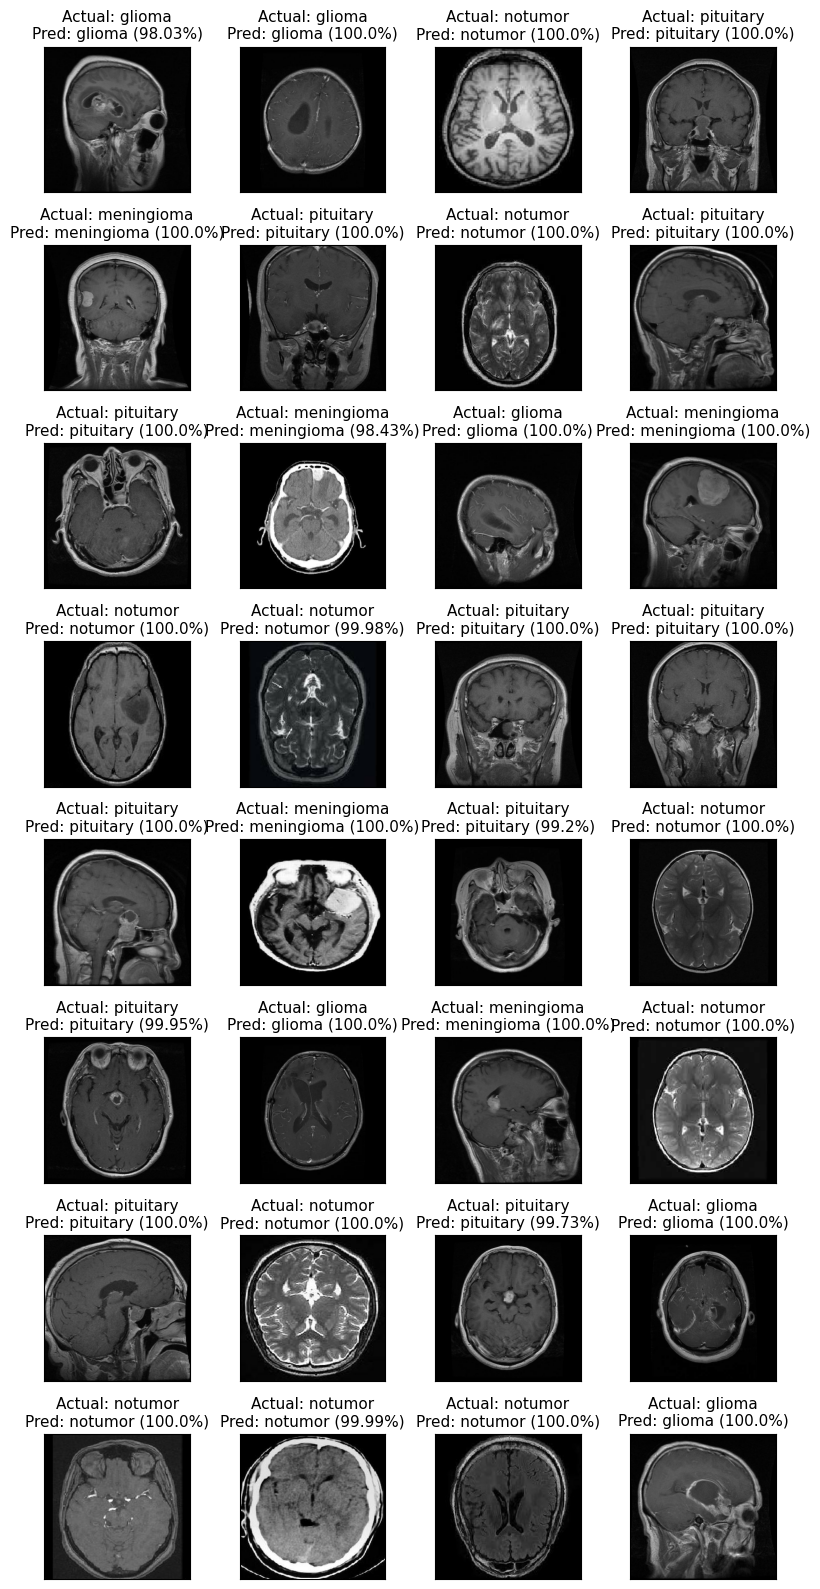

In [38]:
imgs, clss = next(iter(test_set.take(1)))
pred_prob = np.squeeze(model.predict(imgs, verbose=0))
pred_cls = np.argmax(pred_prob, axis=1)

# Create subplots
fig, ax = plt.subplots(8, 4, figsize=(8, 16))
ax = ax.flatten()

# Loop through each image and display it with predicted and actual class
for i, img in enumerate(imgs):
    ax[i].imshow(img)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    # Get the actual class from one-hot encoding (if it's one-hot encoded)
    actual_class = np.argmax(clss[i]) if len(clss[i].shape) > 1 else clss[i]
    
    ax[i].set_title(f'Actual: {class_names[actual_class]}\n'
                    f'Pred: {class_names[pred_cls[i]]} ({round(np.max(pred_prob[i])*100, 2)}%)', fontsize=11)

plt.tight_layout()
plt.show()